# Implementação do Random Forest

In [1]:
TRAINING_DATASET_SOURCE = '../training_data.csv'  # Since we are one directory up, we should go down one directory to import the datasets
TEST_DATASET_SOURCE = '../test_data.csv'

In [2]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# Definição dos dados de teste e de treino

In [3]:
print(train_df.shape, test_df.shape)

(5000, 13) (1206, 12)


In [4]:
train_df['incidents'].value_counts()

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

In [5]:
#count_class0, count_class1, count_class2, count_class3, count_class4 = train_df['incidents'].value_counts().to_frame()

incidents_count = train_df['incidents'].value_counts()

max_count = incidents_count.max()

print('Max value count:', max_count)

df_classes = []
for category, counts in zip(incidents_count.index, incidents_count):
    #print(category, counts)
    df_classes.append(train_df[train_df['incidents'] == category])

df_classes_over = []

for category in df_classes:
    df_classes_over.append(category.sample(max_count, replace=True))

df_test_over = pd.concat(df_classes_over, axis=0)

print(df_test_over['incidents'].value_counts())


Max value count: 2028
None         2028
High         2028
Low          2028
Very_High    2028
Medium       2028
Name: incidents, dtype: int64


In [6]:
dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay', 'record_date', 'affected_roads']

X = df_test_over.drop([*dropped_columns, 'incidents'], axis=1)
y = df_test_over['incidents']

all_features = X.columns.tolist()

In [7]:
X

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain
567,0,DARK,15.0,1014.0,92.0,1.0,Sem Chuva
4816,0,LIGHT,17.0,1020.0,54.0,0.0,Sem Chuva
3133,0,LOW_LIGHT,5.0,1028.0,91.0,0.0,Sem Chuva
2758,0,DARK,13.0,1016.0,92.0,0.0,Sem Chuva
1098,0,DARK,8.0,1027.0,80.0,1.0,Sem Chuva
...,...,...,...,...,...,...,...
2570,1040,LIGHT,14.0,1024.0,48.0,2.0,Sem Chuva
4886,0,DARK,13.0,1013.0,81.0,3.0,Sem Chuva
1274,544,LIGHT,12.0,1024.0,91.0,1.0,Sem Chuva
1003,0,LOW_LIGHT,19.0,1019.0,60.0,1.0,Sem Chuva


In [8]:
numerical_features = [column for column, dtype in zip(X.columns, X.dtypes)
                      if dtype.kind in ['i', 'f']]

categorical_features = [column for column, dtype in zip(X.columns, X.dtypes)
                        if dtype.kind not in ['i', 'f']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2000)

In [10]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(),
        verbose=True,
    ), numerical_features),

    (make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(categories='auto', handle_unknown='ignore'),
        verbose=True

    ), categorical_features),
    verbose=True
)

In [11]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif

preprocessor_best = make_pipeline(preprocessor, VarianceThreshold(), SelectKBest(f_classif, k='all'), verbose=True)

In [12]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators=100), verbose=True)

In [13]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing minmaxscaler, total=   0.0s
[ColumnTransformer] .... (1 of 2) Processing pipeline-1, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing onehotencoder, total=   0.0s
[ColumnTransformer] .... (2 of 2) Processing pipeline-2, total=   0.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.0s
[Pipeline] . (step 2 of 3) Processing variancethreshold, total=   0.0s
[Pipeline] ....... (step 3 of 3) Processing selectkbest, total=   0.0s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   0.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.4s


0.9966187658495351

In [14]:
RF_Model.score(X_test, y_test)

0.9201183431952663

## Hyperparameter Tuning

In [32]:
import numpy as np

n_estimators = [int(x) for x in np.linspace(start=10, stop=20, num=3)]

max_features = ['auto', 'sqrt']

max_depth = [2, 6, 12, 20, 30, 40, 50]

min_samples_split = [2, 5, 30]

min_samples_leaf = [1, 2, 50]

bootstrap = [True, False]

In [33]:
param_grid = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__bootstrap': bootstrap,
}

param_grid

{'randomforestclassifier__n_estimators': [10, 15, 20],
 'randomforestclassifier__max_features': ['auto', 'sqrt'],
 'randomforestclassifier__max_depth': [2, 6, 12, 20, 30, 40, 50],
 'randomforestclassifier__min_samples_split': [2, 5, 30],
 'randomforestclassifier__min_samples_leaf': [1, 2, 50],
 'randomforestclassifier__bootstrap': [True, False]}

In [40]:
rf_RandomGrid = RandomizedSearchCV(estimator=RF_Model, param_distributions=param_grid, cv=200, verbose=3, n_jobs=-1,
                                   n_iter=5)

In [41]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 200 folds for each of 5 candidates, totalling 1000 fits
[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing minmaxscaler, total=   0.0s
[ColumnTransformer] .... (1 of 2) Processing pipeline-1, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing onehotencoder, total=   0.0s
[ColumnTransformer] .... (2 of 2) Processing pipeline-2, total=   0.0s
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.0s
[Pipeline] . (step 2 of 3) Processing variancethreshold, total=   0.0s
[Pipeline] ....... (step 3 of 3) Processing selectkbest, total=   0.0s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   0.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=   0.1s
CPU times: total: 1.97 s
Wall time: 10.4 s


C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=200,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())],
                                                                                                         verbose=True),
                                                                                                ['delay_in_seconds',
                                                                                                 'avg_temperature',
                                                                                                 'avg_atm_pressure',
                                                                                                 'avg_humidity',
                                                                                                 'avg_wind_speed']...
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [2,
                                                                              6,
                                                                              12,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     50],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      30],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 15,
                                                                                 20]},
                   verbose=3)

In [42]:
rf_RandomGrid.score(X_train, y_train)

0.9821076359537898

In [43]:
rf_RandomGrid.best_params_

{'randomforestclassifier__n_estimators': 10,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__bootstrap': False}

In [44]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())],
                                                                            verbose=True),
                                                                   ['delay_in_seconds',
                                                                    'avg_temperature',
                                                                    'avg_atm_pressure',
                                                                    'avg_humidity',
                                                                    'avg_wind_speed']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('si...
                                                                                    OneHotEncoder(handle_unknown='ignore'))],
                                                                            verbose=True),
                                                                   ['luminosity',
                                                                    'avg_rain'])],
                                                    verbose=True)),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k='all'))],
                          verbose=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=20,
                                        max_features='auto', min_samples_leaf=2,
                                        min_samples_split=5,
                                        n_estimators=10))],
         verbose=True)

In [45]:
print(f'Train: {rf_RandomGrid.score(X_train,y_train):.3f}' )
print(f'Test: {rf_RandomGrid.score(X_test,y_test):.3f}' )

Train: 0.982
Test: 0.904


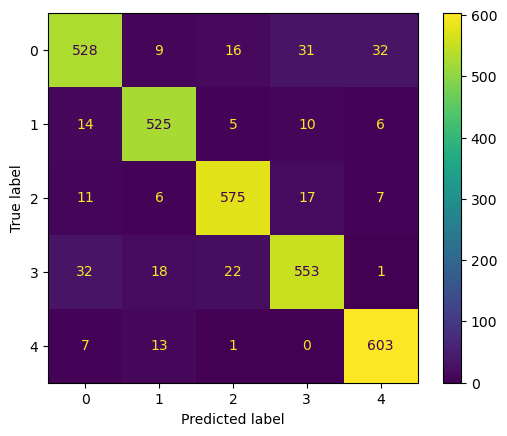

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_RandomGrid.predict(X_test)

cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()